In [11]:
# Imports
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [12]:
# Maps numeric actions to semantic actions
action_map = {
    1: "UP",
    2: "DOWN",
    3: "LEFT",
    4: "RIGHT"
}

In [13]:
# Input q-function --> Output value function
# Used for plotting value grids with imshow
def plot_valuemap(q):
    v = {}
    for row in range(7):
        for col in range(10):
            v[tuple((row,col))] = max([
                q[tuple((row,col,1))],
                q[tuple((row,col,2))], 
                q[tuple((row,col,3))], 
                q[tuple((row,col,4))], 
            ])
    plt.imshow(np.array([*v.values()]).reshape(7,10))
    plt.colorbar()
    plt.show()

In [14]:
# GridWorld Class
class GridWorld:
    
    # Constructor
    def __init__(self):
        # Rewards
        self.world = np.array([
            [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [-1, -1, -1, -1, -1, -1, -1, +1, -1, -1],
            [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
            [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        ])
        # Wind
        self.wind = np.array([
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
            [0, 0, 0, 1, 1, 1, 2, 2, 1, 0],
        ])

    # Input x, y, and numeric action --> Output new unclipped x, y
    def step(self, x, y, action):
        wind = self.wind[x][y]
        if action == 1:
            return x-1, y, wind
        elif action == 2:
            return x+1, y, wind
        elif action == 3:
            return x, y-1, wind
        elif action == 4:
            return x, y+1, wind
        
    # Input x, y --> Output reward
    def reward(self, x, y, wind):
        if x not in range(0,7) or y not in range(0,10):
            return -1
        else:
            return self.world[np.clip(x-wind, 0, 6)][y]
        
    # Input x, y --> Output True if position is terminal state else False
    def terminated(self, x, y):
        return True if (x==3 and y==7) else False

In [15]:
# Agent class
class Agent:
    
    # Constructor
    def __init__(self):
        self.gridworld = GridWorld()
        self.x = 3
        self.y = 0
        self.x_prev = None
        self.y_prev = None
        self.gamma = 0.9
        self.epsilon = 0.1
        self.S = []
        self.q = {tuple([row, col, action]): np.random.normal(-1, 1) for row in range(self.gridworld.world.shape[0]) for col in range(self.gridworld.world.shape[1]) for action in action_map.keys()}
        self.p = {tuple([row, col]): max(action_map.keys(), key = lambda a: self.q[tuple([row, col, a])]) for row in range(self.gridworld.world.shape[0]) for col in range(self.gridworld.world.shape[1])}
        self.r = {tuple([row, col, action]): [] for row in range(self.gridworld.world.shape[0]) for col in range(self.gridworld.world.shape[1]) for action in action_map.keys()}
    
    # Wrapper function for GridWorld.step()
    def step(self, action):
        self.x_prev = self.x
        self.y_prev = self.y
        self.x, self.y, wind = self.gridworld.step(self.x, self.y, action)
        reward = self.gridworld.reward(self.x, self.y, wind)
        self.x = np.clip(self.x-wind, 0, 6)
        self.y = np.clip(self.y, 0, 9)
        return reward
    
    def reset(self):
        self.x = 3
        self.y = 0
    
    # Wrapper function for GridWorld.reward()
    def reward(self):
        return self.gridworld.reward(self.x, self.y)
    
    # Wrapper function for GridWorld.terminated()
    def terminated(self):
        return self.gridworld.terminated(self.x, self.y)
    
    # Wrapper function for GridWorld.terminated()
    def empty_s(self):
        self.S = []
    
    # Monte Carlo control on-policy policy evaluation (for e-soft policies)
    def MC(self, max_steps=np.inf, max_moves=100, epsilon=0.1, N=300):
        axis_timesteps, axis_episodic = [], []
        episode_count = 0
        steps_count = 0
        finished = False
        while episode_count < N:
            last_g = None
            self.reset()
            episode = []
            for move in range(max_moves):
                if np.random.choice([True, False], p=[epsilon, 1-epsilon]):
                    action = random.choice(list(action_map.keys()))
                else:
                    action = self.p[tuple([self.x, self.y])]
                reward = self.step(action)
                steps_count+=1
                episode.append(tuple([tuple([self.x_prev, self.y_prev]), action, reward]))
                if self.terminated():
                    axis_timesteps.append(steps_count)
                    axis_episodic.append(episode_count)
                    break
                else:
                    axis_timesteps.append(steps_count)
                    axis_episodic.append(episode_count)
                    
            episode_count+=1
            G = 0
            for T, step in enumerate(reversed(episode)):
                state, action, reward = step
                G = self.gamma * G + reward
                if not any([(state, action) == row for row in [(x[0], x[1]) for x in episode[:-T-1]]]):
                    if state == tuple([3,0]):
                        last_g = G
#                     sa = tuple([state[0], state[1], action])
#                     self.r[sa].append(G)
#                     self.q[sa] = np.mean(self.r[sa])
#                     self.p[state] = max(action_map.keys(), key = lambda a: self.q[tuple([state[0], state[1], a])])
            self.S.append(last_g)
                    
    # SARSA on-policy (TD control)
    def SARSA(self, N=100):
        axis_timesteps, axis_episodic = [], []
        episode_count = 0
        step_count = 0
        alpha = 0.5
        epsilon = 0.1
        self.q[tuple([3,7,1])] = 0
        self.q[tuple([3,7,2])] = 0
        self.q[tuple([3,7,3])] = 0
        self.q[tuple([3,7,4])] = 0
        while episode_count < N:
            self.reset()
            while True:
                if np.random.choice([True, False], p=[epsilon, 1-epsilon]):
                    A1 = random.choice(list(action_map.keys()))
                else:
                    A1 = max(action_map.keys(), key = lambda a: self.q[tuple([self.x, self.y, a])])
                reward = self.step(A1)
                if np.random.choice([True, False], p=[epsilon, 1-epsilon]):
                    A2 = random.choice(list(action_map.keys()))
                else:
                    A2 = max(action_map.keys(), key = lambda a: self.q[tuple([self.x, self.y, a])])
                step_count+=1
                sa1 = tuple([self.x_prev, self.y_prev, A1])
                sa2 = tuple([self.x, self.y, A2])
                self.q[sa1] = self.q[sa1] + alpha * ( reward + self.gamma * self.q[sa2] - self.q[sa1])
                if self.terminated():
                    episode_count+=1
                    axis_timesteps.append(step_count)
                    axis_episodic.append(episode_count)
                    break
                else:
                    axis_timesteps.append(step_count)
                    axis_episodic.append(episode_count)
        for row in range(7):
            for col in range(10):
                agent.p[tuple([row,col])] = max(action_map.keys(), key = lambda a: agent.q[tuple([row, col, a])])
    
    # n-step SARSA with n = 4
    def nstepSARSA(self, n=4, N=100, max_moves=100):
        axis_timesteps, axis_episodic = [], []
        episode_count = 0
        step_count = 0
        lr = 0.5
        epsilon = 0.1
        finished = False
        while episode_count < N:
            self.reset()
            t = 0
            T = np.inf
            action = self.p[tuple([self.x, self.y])]
            actions = [action]
            states = [tuple([self.x, self.y])]
            rewards = [0]
            for move in range(max_moves):
                if t < T:
                    reward = self.step(action)
                    state = tuple([self.x, self.y])

                    states.append(state)
                    rewards.append(reward)

                    if self.terminated():
                        T = t + 1
                    else:
                        if np.random.choice([True, False], p=[epsilon, 1-epsilon]):
                            action = random.choice(list(action_map.keys()))
                        else:
                            action = max(action_map.keys(), key = lambda a: self.q[tuple([self.x, self.y, a])])
                        actions.append(action)  
                tau = t - n + 1
                step_count+=1
                axis_timesteps.append(step_count)
                axis_episodic.append(episode_count)
                if tau >= 0:
                    G = 0
                    for i in range(tau + 1, min(tau + n + 1, T + 1)):
                        G += np.power(self.gamma, i - tau - 1) * rewards[i]
                    if tau + n < T:
                        state_action = (states[tau + n], actions[tau + n])
                        state_action = [*state_action[0]] + [state_action[1]]
                        G += np.power(self.gamma, n) * self.q[tuple(state_action)]
                    if tau == 0:
                        self.S.append(G)
#                     state_action = (states[tau], actions[tau])
#                     state_action = [*state_action[0]] + [state_action[1]]
#                     self.q[tuple(state_action)] += lr * (
#                                 G - self.q[tuple(state_action)])
                if tau == T - 1:
                    break

                t += 1
            episode_count+=1

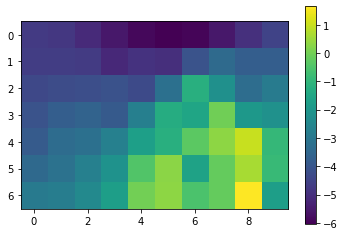

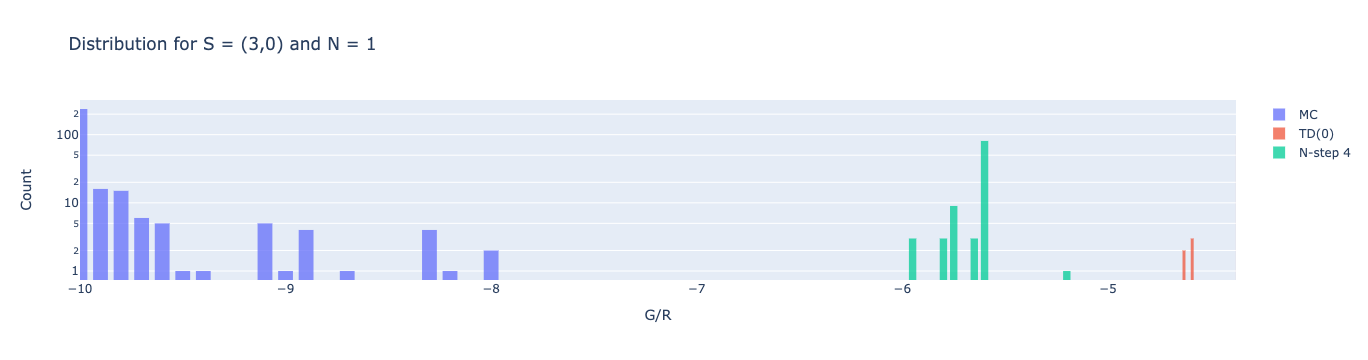

In [20]:
agent = Agent()
agent.SARSA(N=10)
plot_valuemap(agent.q)

minimum = +np.Inf
maximum = -np.Inf

fig = go.Figure()

agent.MC()
fig.add_trace(go.Histogram(x=agent.S, name='MC'))
minimum = min(min(agent.S), minimum)
maximum = max(max(agent.S), maximum)
agent.empty_s()

agent.nstepSARSA(n=1)
fig.add_trace(go.Histogram(x=agent.S, name='TD(0)'))
minimum = min(min(agent.S), minimum)
maximum = max(max(agent.S), maximum)
agent.empty_s()

agent.nstepSARSA(n=4)
fig.add_trace(go.Histogram(x=agent.S, name='N-step 4'))
minimum = min(min(agent.S), minimum)
maximum = max(max(agent.S), maximum)
agent.empty_s()


fig.update_layout(
    title_text='Distribution for S = (3,0) and N = 1', # title of plot
    xaxis_title_text='G/R', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    showlegend=True,
    barmode='overlay',
    xaxis_range=[minimum,maximum]

)

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.update_yaxes(type="log")
fig.show()

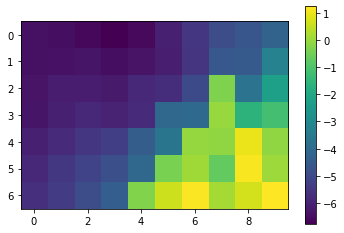

Monte Carlo
TD(0)
N-step 4


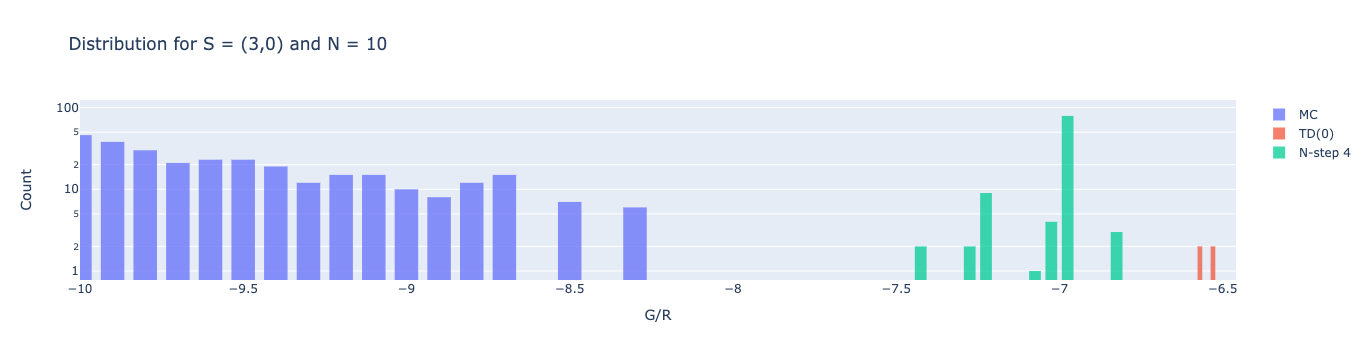

In [21]:
agent = Agent()
agent.SARSA(N=50)
plot_valuemap(agent.q)

minimum = +np.Inf
maximum = -np.Inf

fig = go.Figure()

print("Monte Carlo")
agent.MC()
fig.add_trace(go.Histogram(x=agent.S, name='MC'))
minimum = min(min(agent.S), minimum)
maximum = max(max(agent.S), maximum)
agent.empty_s()

print("TD(0)")
agent.nstepSARSA(n=1)
fig.add_trace(go.Histogram(x=agent.S, name='TD(0)'))
minimum = min(min(agent.S), minimum)
maximum = max(max(agent.S), maximum)
agent.empty_s()

print("N-step 4")
agent.nstepSARSA(n=4)
fig.add_trace(go.Histogram(x=agent.S, name='N-step 4'))
minimum = min(min(agent.S), minimum)
maximum = max(max(agent.S), maximum)
agent.empty_s()


fig.update_layout(
    title_text='Distribution for S = (3,0) and N = 10', # title of plot
    xaxis_title_text='G/R', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    showlegend=True,
    barmode='overlay',
    xaxis_range=[minimum,maximum]

)

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.update_yaxes(type="log")
fig.show()

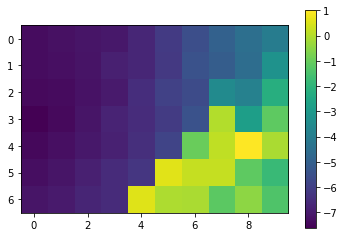

Monte Carlo
TD(0)
N-step 4


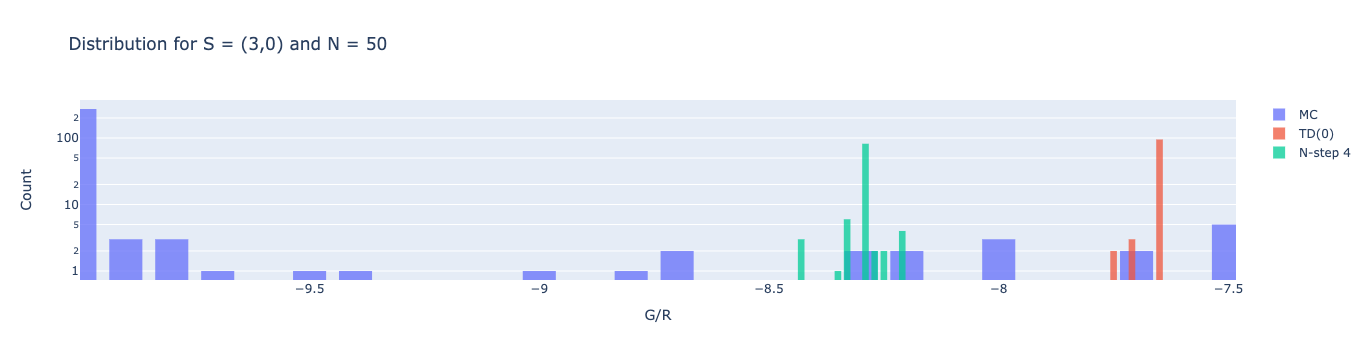

In [22]:
agent = Agent()
agent.SARSA(N=100)
plot_valuemap(agent.q)

minimum = +np.Inf
maximum = -np.Inf

fig = go.Figure()

print("Monte Carlo")
agent.MC()
fig.add_trace(go.Histogram(x=agent.S, name='MC'))
minimum = min(min(agent.S), minimum)
maximum = max(max(agent.S), maximum)
agent.empty_s()

print("TD(0)")
agent.nstepSARSA(n=1)
fig.add_trace(go.Histogram(x=agent.S, name='TD(0)'))
minimum = min(min(agent.S), minimum)
maximum = max(max(agent.S), maximum)
agent.empty_s()

print("N-step 4")
agent.nstepSARSA(n=4)
fig.add_trace(go.Histogram(x=agent.S, name='N-step 4'))
minimum = min(min(agent.S), minimum)
maximum = max(max(agent.S), maximum)
agent.empty_s()


fig.update_layout(
    title_text='Distribution for S = (3,0) and N = 50', # title of plot
    xaxis_title_text='G/R', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1, # gap between bars of the same location coordinates
    showlegend=True,
    barmode='overlay',
    xaxis_range=[minimum,maximum]

)

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.update_yaxes(type="log")
fig.show()